In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import kernels
import knn


In [4]:
data = pd.read_csv("https://www.openml.org/data/get_csv/53983/PopularKids.arff")
data.head()


,Gender,Grade,Age,Race,Urban/Rural,School,Goals,Grades,Sports,Looks,Money
0,'boy',5,11,'White','Rural','Elm','Sports',1,2,4,3
1,'boy',5,10,'White','Rural','Elm','Popular',2,1,4,3
2,'girl',5,11,'White','Rural','Elm','Popular',4,3,1,2
3,'girl',5,11,'White','Rural','Elm','Popular',2,3,4,1
4,'girl',5,10,'White','Rural','Elm','Popular',4,2,1,3


In [5]:
data.drop("School", axis=1, inplace=True)
data = pd.get_dummies(data, columns=["Urban/Rural"])
data["Race"] = pd.factorize(data["Race"])[0]
data["Gender"] = pd.factorize(data["Gender"])[0]
data["Goals"] = pd.factorize(data["Goals"])[0]

for column in ["Grade", "Age", "Grades", "Looks", "Money"]:
    data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())

n_classes = 3

data.head()


,Gender,Grade,Age,Race,Goals,Grades,Sports,Looks,Money,Urban/Rural_'Rural',Urban/Rural_'Suburban',Urban/Rural_'Urban'
0,0,0.5,0.666667,0,0,0.000000,2,1.0,0.666667,1,0,0
1,0,0.5,0.500000,0,1,0.333333,1,1.0,0.666667,1,0,0
2,1,0.5,0.666667,0,1,1.000000,3,0.0,0.333333,1,0,0
3,1,0.5,0.666667,0,1,0.333333,3,1.0,0.000000,1,0,0
4,1,0.5,0.500000,0,1,1.000000,2,0.0,0.666667,1,0,0


In [6]:
x_train, x_test, y_train, y_test = \
    train_test_split(data.drop("Goals", axis=1), data["Goals"], test_size=(478 - 200) / 478, random_state=1)

print("train: {} samples, test: {} samples".format(len(x_train), len(x_test)))


train: 200 samples, test: 278 samples


In [7]:
dist_fs = [kernels.manhattan, kernels.euclidean, kernels.chebyshev]
kernel_fs = [kernels.uniform, kernels.triangular, kernels.epanechnikov, kernels.quartic, kernels.triweight, kernels.gaussian, kernels.cosine, kernels.logistic, kernels.sigmoid, kernels.tricube]


In [8]:
LEARN = False

if LEARN:
    ks = [1, 2, 4, 7, 11, 16, 22, 29, 37, 46, 56, 79, 106, 121, 151, 199]
    for k in ks:
        for dist_f in dist_fs:
            for kernel_f in kernel_fs:
                result = np.zeros((n_classes, n_classes))
                margins = []
                for i, sample in x_train.iterrows():
                    model = knn.KNN(x_train.drop(i), y_train.drop(i), k=k, dist_f=dist_f, kernel_f=kernel_f)
                    predict_y, margin = model.run(sample, y_train[i])
                    margins.append(margin)
                    result[predict_y][y_train[i]] += 1
                print("{:6} : k={:3}, dist={:8}, kernel={:8}".format(kernels.f_score(result)[0], k, dist_f.__name__, kernel_f.__name__))

    ds = [0.01, 0.1, 0.5, 1.0, 2.0, 4.0, 6.0, 8.0, 12.0]
    for d in ds:
        for dist_f in dist_fs:
            for kernel_f in kernel_fs:
                result = np.zeros((n_classes, n_classes))
                margins = []
                for i, sample in x_train.iterrows():
                    model = knn.KNN(x_train.drop(i), y_train.drop(i), d=d, dist_f=dist_f, kernel_f=kernel_f)
                    predict_y, margin = model.run(sample, y_train[i])
                    margins.append(margin)
                    result[predict_y][y_train[i]] += 1
                print("{:6} : d={:5}, dist={:8}, kernel={:8}".format(kernels.f_score(result)[0], d, dist_f.__name__, kernel_f.__name__))


In [9]:
k = 4
dist_f = kernels.euclidean
kernel_f = kernels.logistic

result = np.zeros((n_classes, n_classes))
margins = []

model = knn.KNN(x_train, y_train, k=k, dist_f=dist_f, kernel_f=kernel_f)

for i, sample in x_train.iterrows():
    predict_y, margin = model.run(sample, y_train[i])
    result[predict_y][y_train[i]] += 1
    margins.append(margin)
print("{} : k={}, dist={}, kernel={}".format(kernels.f_score(result)[0], k, dist_f.__name__, kernel_f.__name__))
# sns.kdeplot(margins)


0.6878005885910644 : k=4, dist=euclidean, kernel=logistic


In [10]:
train_margins = pd.Series(margins)

def get_filtered(border):
    x_filtered = x_train[(train_margins > border).values]
    y_filtered = y_train[(train_margins > border).values]
    return x_filtered, y_filtered

x_filtered0, y_filtered0 = get_filtered(0)
x_filtered3, y_filtered3 = get_filtered(-3)
x_filtered5, y_filtered5 = get_filtered(-5)
x_filtered7, y_filtered7 = get_filtered(-7)
x_filtered9, y_filtered9 = get_filtered(-9)



[[  0.   0.   0.]
 [  0.   1.   1.]
 [ 51.  83. 142.]]
0.6760622432189793 : k=4, dist=euclidean, kernel=logistic, name=train


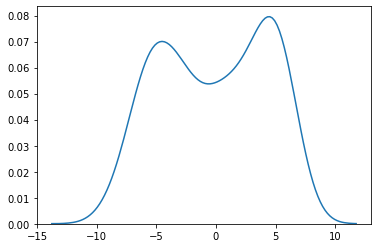

[[  0.   0.   0.]
 [  0.   0.   0.]
 [ 51.  84. 143.]]
0.6793349168646081 : k=4, dist=euclidean, kernel=logistic, name=filtered0


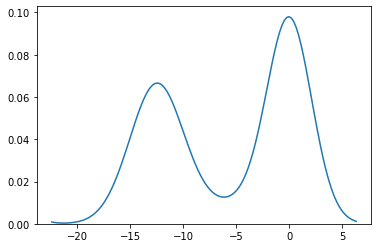

[[  0.   0.   0.]
 [  0.   0.   0.]
 [ 51.  84. 143.]]
0.6793349168646081 : k=4, dist=euclidean, kernel=logistic, name=filtered3


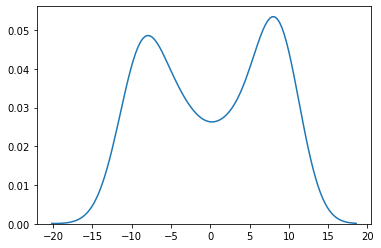

[[  0.   0.   0.]
 [  0.   0.   0.]
 [ 51.  84. 143.]]
0.6793349168646081 : k=4, dist=euclidean, kernel=logistic, name=filtered5


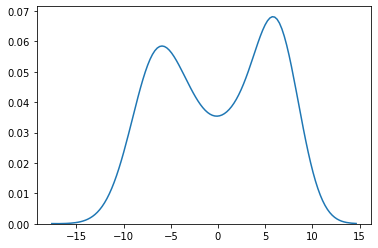

In [11]:
def run_test(k, dist_f, kernel_f, x_train, y_train, name):
    result = np.zeros((n_classes, n_classes))
    margins = []
    model = knn.KNN(x_train, y_train, k=k, dist_f=dist_f, kernel_f=kernel_f)
    for i, sample in x_test.iterrows():
        predict_y, margin = model.run(sample, y_test[i])
        result[predict_y][y_test[i]] += 1
        margins.append(margin)
    print(result)
    print("{} : k={}, dist={}, kernel={}, name={}".format(kernels.f_score(result)[0], k, dist_f.__name__, kernel_f.__name__, name))
    sns.kdeplot(margins)
    plt.show()


run_test(4, kernels.euclidean, kernels.logistic, x_train, y_train, "train")
run_test(4, kernels.euclidean, kernels.logistic, x_filtered0, y_filtered0, "filtered0")
run_test(4, kernels.euclidean, kernels.logistic, x_filtered3, y_filtered3, "filtered3")
run_test(4, kernels.euclidean, kernels.logistic, x_filtered5, y_filtered5, "filtered5")
run_test(4, kernels.euclidean, kernels.logistic, x_filtered7, y_filtered7, "filtered7")
run_test(4, kernels.euclidean, kernels.logistic, x_filtered9, y_filtered9, "filtered9")


